In [1]:
import matplotlib.pyplot as plt
import numpy as np
from brian2.only import *
import seaborn as sns
import deepdish as dd
import scipy.stats as stats

import plot_utils as pu
from digest import conds
import isi_indexing as ii
from readout import load_results

import conf.isi5_500 as cfg
from demonstrator import demonstrator
from dish import dish

import styling

In [2]:
# on mouse:
import conf.isi5_mouse as cfm
cfg.fname = cfg.fname.replace(cfg.fbase, cfm.fbase)
cfg.netfile = cfg.netfile.replace(cfg.fbase, cfm.fbase)
cfg.digestfile = cfg.digestfile.replace(cfg.fbase, cfm.fbase)
cfg.fbase = cfm.fbase
cfg.raw_fbase = cfg.fname[:-3]

In [3]:
def index(n0, n1):
    return ((n0-n1)/(n0+n1))

In [4]:
def label(STD, TA):
    if STD and TA:
        return 'STD+TA'
    elif STD:
        return 'STD only'
    elif TA:
        return 'TA only'
    return 'no plasticity'

In [5]:
plasticity = [(TA, STD) for TA in cfg.TAs for STD in cfg.STDs]

In [6]:
isi = cfg.ISIs[0]
templ = 0

In [7]:
nspikes = dd.io.load('Fig5n-stats.h5')

# Figure 3

In [8]:
net, ipair, istim = [demonstrator[k] for k in ('net', 'ipair', 'istim')]
pair, stim = cfg.pairings[ipair], cfg.pairings[ipair][istim]
templ = 'R'
tmax = 0
pmax = 0
hists = {STD: {TA: None for TA in cfg.TAs} for STD in cfg.STDs}
for STD in cfg.STDs:
    for TA in cfg.TAs:
        res = load_results(
            cfg.fname.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ),
            compress=True, tmax=100*ms, process_dynamics=False,
            raw_fbase=cfg.raw_fbase.format(net=net, isi=isi, STD=STD, TA=TA, templ=templ))
        histograms = {cond: res['spikes'][ipair][stim][cond]['spike_hist']
                      for cond in conds}
        index_N, index_t = ii.get_onset_ordering(cfg, np.stack([h for h in histograms.values()]))
        tmax = max(tmax, np.max(index_t)+1)
        hists[STD][TA] = histograms
        pmax = max(pmax, *[h.sum(0).max() for h in histograms.values()])

In [9]:
_pmax = np.amax([hists[STD][TA][cond].sum(0) for STD in cfg.STDs for TA in cfg.TAs for cond in conds], 0)
tmax = np.argmax(np.cumsum(_pmax > .01*pmax))

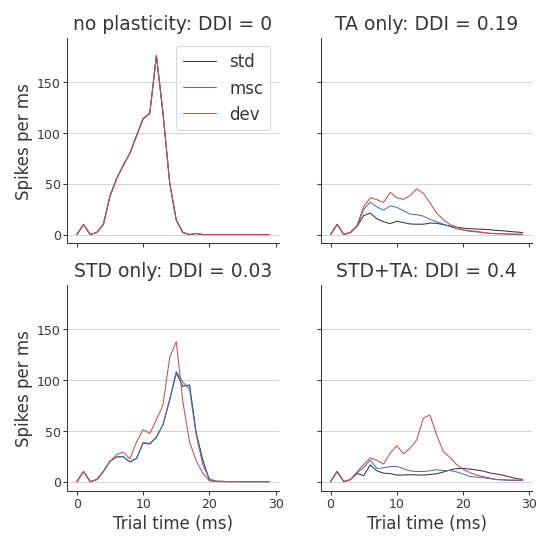

In [10]:
def panel_samples(axs):
    time = np.arange(tmax) * cfg.params['dt']
    for axr, STD in zip(axs, cfg.STDs):
        axr[0].set_ylabel('Spikes per ms')
        for ax, TA in zip(axr, cfg.TAs):
            histograms = hists[STD][TA]
            for cond, h in histograms.items():
                pspike = h.sum(0)[:tmax]
                ax.plot(time/ms, pspike, c=pu.colors[cond], label=cond)
            if STD:
                ax.set_xlabel('Trial time (ms)')
            ax.set_title(f'{label(STD, TA)}: DDI = {index(histograms["dev"].sum(), histograms["msc"].sum()):.2g}')
            ax.set_ylim(top=1.1*pmax)
            ax.yaxis.grid(True)
            sns.despine(ax=ax)
    axs[0][0].legend()
fig, axs = plt.subplots(2, 2, figsize=(4,4), sharex=True, sharey=True, dpi=150)
panel_samples(axs)

Deviance detection index
no plasticity != 0: t = nan, p = nan
no plasticity > 0: t = nan, p = nan, median 0.0
STD only != 0: t = -1.89, p = 0.0609
STD only > 0: t = -1.89, p = 0.97, median -0.000214107114011532
TA only > 0: t = 5.52, p = 1.01e-07, median 0.07717049278368518
STD+TA > 0: t = 6.49, p = 1.05e-09, median 0.11360838842772791


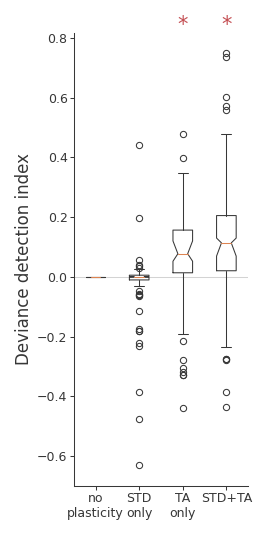

In [11]:
def panel_stats(ax, c0='dev', c1='msc', ylabel='Deviance detection index'):
    idx = [index(nspikes[STD][TA][c0], nspikes[STD][TA][c1]) for TA, STD in plasticity]
    labels = [label(STD, TA) for TA, STD in plasticity]
    ax.boxplot(idx, notch=True, bootstrap=10000)
    ax.set_xticks(range(1,5), [l.replace(' ', '\n') for l in labels])
    ax.set_ylabel(ylabel)
    ax.axhline(0, color='lightgrey', zorder=0)
    sns.despine(ax=ax)

    print(ylabel)
    imax = np.amax(idx)
    for i, ix in enumerate(idx):
        test = stats.ttest_1samp(ix, 0, alternative='greater')
        if test.pvalue < .05:
            ax.text(i+1, 1.1*imax, '*', {'color': 'r', 'ha': 'center'})
        else:
            test2 = stats.ttest_1samp(ix, 0, alternative='two-sided')
            print(f'{labels[i]} != 0: t = {test2.statistic:.3g}, p = {test2.pvalue:.3g}')
        print(f'{labels[i]} > 0: t = {test.statistic:.3g}, p = {test.pvalue:.3g}, median {np.median(ix)}')

fig, ax = plt.subplots(figsize=(1.5,4), dpi=150)
panel_stats(ax)

DDI
no plasticity != 0: t = nan, p = nan
no plasticity > 0: t = nan, p = nan, median 0.0
STD only != 0: t = -1.89, p = 0.0609
STD only > 0: t = -1.89, p = 0.97, median -0.000214107114011532
TA only > 0: t = 5.52, p = 1.01e-07, median 0.07717049278368518
STD+TA > 0: t = 6.49, p = 1.05e-09, median 0.11360838842772791
SSA index
no plasticity != 0: t = nan, p = nan
no plasticity > 0: t = nan, p = nan, median 0.0
STD only > 0: t = 3.17, p = 0.000983, median 0.0038999537066708905
TA only > 0: t = 6.74, p = 3e-10, median 0.09671771131687126
STD+TA > 0: t = 7.84, p = 1.05e-12, median 0.13544250155423743


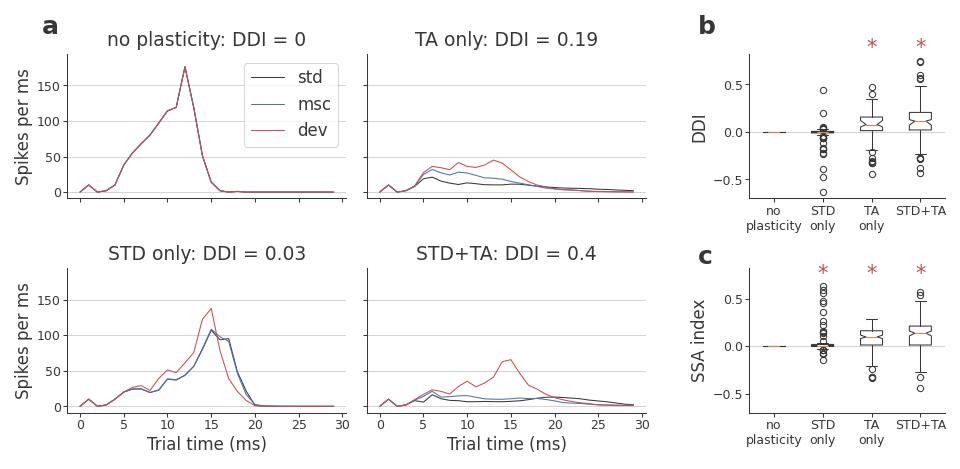

In [12]:
fig = plt.figure(figsize=(6.29, 3), layout='constrained', dpi=150)
gs = fig.add_gridspec(3, 4, height_ratios=(.1, 1, 1), width_ratios=(2, 2, .2, 1.4))

axs = [[None for TA in cfg.TAs] for STD in cfg.STDs]
for STD in cfg.STDs:
    for TA in cfg.TAs:
        if STD or TA:
            axs[STD][TA] = fig.add_subplot(gs[STD+1, TA], sharex=axs[0][0], sharey=axs[0][0])
        else:
            axs[STD][TA] = fig.add_subplot(gs[STD+1, TA])
        axs[STD][TA].label_outer()
panel_samples(axs)

ax = fig.add_subplot(gs[1, 3])
panel_stats(ax, ylabel='DDI')
panel_stats(fig.add_subplot(gs[2, 3], sharey=ax), 'msc', 'std', 'SSA index')

fig.text(.035, .99, 'a', **styling.label_kwargs, va='top')
fig.text(.73, .99, 'b', **styling.label_kwargs, va='top')
fig.text(.73, .48, 'c', **styling.label_kwargs, va='top')

plt.savefig('paper-1/fig3.pdf')

# Figure 2

In [13]:
phenostrator = dict(net=26, ipair=0, istim=0)
net, ipair, istim = [phenostrator[k] for k in ('net', 'ipair', 'istim')]
pair, stim = cfg.pairings[ipair], cfg.pairings[ipair][istim]

res = load_results(
    cfg.fname.format(net=net, isi=isi, STD=1, TA=1, templ=templ),
    compress=True, tmax=100*ms, process_dynamics=False)
histograms = {cond: res['spikes'][ipair][stim][cond]['spike_hist']
                for cond in conds}
index_N, index_t = ii.get_onset_ordering(cfg, np.stack([h for h in histograms.values()]))
response_model = {cond: h.sum(0) for cond, h in histograms.items()}

In [14]:
pmax = np.max([h.max() for h in response_model.values()])
_pmax = np.amax([h for h in response_model.values()], 0)
tmax = np.argmax(np.cumsum(_pmax > .01*pmax))
response_model = {cond: h.sum(0)[:tmax] for cond, h in histograms.items()}

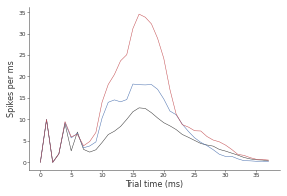

In [15]:
def panel_response(ax, response, dt, ylabel='Spikes per ms'):
    for cond in conds:
        ax.plot(np.arange(len(response[cond])) * dt/ms, response[cond][:tmax], c=pu.colors[cond], label=cond)
    ax.set_xlabel('Trial time (ms)')
    ax.set_ylabel(ylabel)
    sns.despine(ax=ax)

fig, ax = plt.subplots(figsize=(4.5,3))
panel_response(ax, response_model, cfg.params['dt'])

<dev-std> > 0 : t = 11.3, p = 6.7e-21, median 0.2528091492263983
<msc-std> > 0 : t = 7.84, p = 1.05e-12, median 0.13544250155423743
<dev-msc> > 0 : t = 6.49, p = 1.05e-09, median 0.11360838842772791


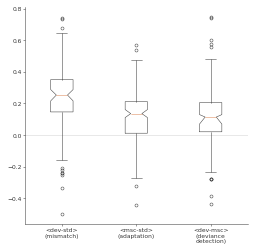

In [16]:
def panel_stats_2(ax):
    n = nspikes[1][1]
    ax.axhline(0, color='lightgrey', zorder=0)
    ax.boxplot((
        index(n['dev'], n['std']),
        index(n['msc'], n['std']),
        index(n['dev'], n['msc']),
    ), notch=True, bootstrap=10000)
    ax.set_xticks(range(1,4), ('<dev-std>\n(mismatch)', '<msc-std>\n(adaptation)', '<dev-msc>\n(deviance\ndetection)'))
    sns.despine(ax=ax)

    for n0,n1 in (('dev', 'std'), ('msc','std'), ('dev','msc')):
        ix = index(n[n0], n[n1])
        test = stats.ttest_1samp(ix, 0, alternative='greater')
        print(f'<{n0}-{n1}> > 0 : t = {test.statistic:.3g}, p = {test.pvalue:.3g}, median {np.median(ix)}')

fig, ax = plt.subplots(figsize=(4,4))
panel_stats_2(ax)

<dev-std> > 0 : t = 11.3, p = 6.7e-21, median 0.2528091492263983
<msc-std> > 0 : t = 7.84, p = 1.05e-12, median 0.13544250155423743
<dev-msc> > 0 : t = 6.49, p = 1.05e-09, median 0.11360838842772791


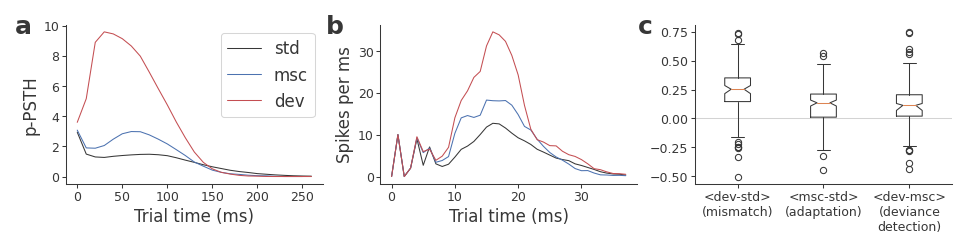

In [17]:
fig = plt.figure(figsize=(6.29, 1.5), dpi=150, layout='constrained')
gs = fig.add_gridspec(1, 3)

ax4 = fig.add_subplot(gs[0])
panel_response(ax4, dish, dish['dt'], ylabel='p-PSTH')
ax4.legend()

ax2 = fig.add_subplot(gs[1])
panel_response(ax2, response_model, cfg.params['dt'])

ax3 = fig.add_subplot(gs[2])
panel_stats_2(ax3)

for x, a in zip((0, .33, .66), 'abc'):
    fig.text(x, 1, a, **styling.label_kwargs, va='top')

plt.savefig('paper-1/fig2.pdf')